# AI for Healthcare Assignment 2
**Cornelius Yap**  
**1003358**

In [1]:
import pandas as pd
import numpy as np
import os,sys
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.losses import MeanSquaredError
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import math
from datetime import datetime, date, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

In [2]:
def config_gpu():
    #Configure Gpus
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
      try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
      except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
config_gpu()

1 Physical GPUs, 1 Logical GPUs


## Understanding the data

#### Loading the dataset

In [4]:
data = pd.read_csv("HDeviceCGM.csv")
data.head(20)

RecID  ParentHDeviceUploadsID  PtID  SiteID  DeviceDtTmDaysFromEnroll  \
0   15047224                    4110    14       9                         6   
1   15047225                    4110    14       9                         6   
2   15047226                    4110    14       9                         6   
3   15047227                    4110    14       9                         6   
4   15047228                    4110    14       9                         6   
5   15047229                    4110    14       9                         6   
6   15047230                    4110    14       9                         6   
7   15047231                    4110    14       9                         6   
8   15047232                    4110    14       9                         6   
9   15047233                    4110    14       9                         6   
10  15047234                    4110    14       9                         6   
11  15047235                    4110    14       9                         6   
12  15047236                    4110    14       9                         6   
13  15047237                    4110    14       9                         6   
14  15047238                    4110    14       9                         6   
15  15047239                    4110    14       9                         6   
16  15047240                    4110    14       9                         6   
17  15047241                    4110    14       9                         6   
18  15047242                    4110    14       9                         6   
19  15047243                    4110    14       9                         6   

    DeviceTm  DexInternalDtTmDaysFromEnroll DexInternalTm RecordType  \
0   10:56:34                              6      18:56:35        CGM   
1   10:51:34                              6      18:51:35        CGM   
2   10:46:34                              6      18:46:35        CGM   
3   10:41:34                              6      18:41:35        CGM   
4   10:36:34                              6      18:36:35        CGM   
5   10:31:34                              6      18:31:35        CGM   
6   10:26:34                              6      18:26:35        CGM   
7   10:21:34                              6      18:21:35        CGM   
8   10:16:34                              6      18:16:35        CGM   
9   10:11:34                              6      18:11:35        CGM   
10  10:06:34                              6      18:06:35        CGM   
11  10:01:34                              6      18:01:35        CGM   
12   9:56:34                              6      17:56:35        CGM   
13   9:51:34                              6      17:51:35        CGM   
14   9:46:38                              6      17:46:39        CGM   
15   9:41:34                              6      17:41:35        CGM   
16   9:36:34                              6      17:36:35        CGM   
17   9:31:34                              6      17:31:35        CGM   
18   9:26:34                              6      17:26:35        CGM   
19   9:21:34                              6      17:21:35        CGM   

    GlucoseValue  
0             76  
1             75  
2             74  
3             72  
4             71  
5             67  
6             64  
7             60  
8             57  
9             55  
10            54  
11            55  
12            55  
13            55  
14            56  
15            61  
16            62  
17            62  
18            64  
19            65

#### Understanding the Different Values in each Category

In [5]:
print(data.ParentHDeviceUploadsID.unique())
print(data.PtID.unique())
print(data.SiteID.unique())
print(data.DeviceDtTmDaysFromEnroll.unique())
print(data.DexInternalDtTmDaysFromEnroll.unique())
print(data.RecordType.unique())

[4110]
[14]
[9]
[ 6 10  8  5  2  1  7  9  4  3  0]
[ 6 11 10  8  5  3  2  1  7  9  4]
['CGM' 'Calibration']


#### Cleaning up the Dataframe

In [6]:
#Remove the unnecessary columns
data_cleaned = data.drop(columns = ['ParentHDeviceUploadsID', 'PtID',
                                   'SiteID', 'DexInternalDtTmDaysFromEnroll',
                                   'DexInternalTm'])

#Remove the data points where the RecordType is Calibration
data_cleaned.drop(data_cleaned.loc[data_cleaned['RecordType']=='Calibration'].index,
                 inplace=True)

#Remove the data points with missing values
data_cleaned.dropna()

#Convert the time to a DateTime Object
data_cleaned['DeviceTm'] =  pd.to_datetime(data_cleaned['DeviceTm'], 
                                           format='%H:%M:%S').dt.time

#Sort the Dataframe in accordance to time
data_cleaned.sort_values(by=['DeviceDtTmDaysFromEnroll', 'DeviceTm'],
                         inplace = True)

#Reset the index of the Dataframe
data_cleaned.reset_index(drop=True, inplace=True)

#Rename the long name
data_cleaned.rename(columns={"DeviceDtTmDaysFromEnroll":"Days"}, inplace = True)

#Print out the entire Dataframe for checking purposes
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(data_cleaned)

         RecID  Days  DeviceTm RecordType  GlucoseValue
0     15055588     0  16:06:58        CGM            48
1     15055587     0  16:11:58        CGM            51
2     15055586     0  16:16:58        CGM            52
3     15055585     0  16:21:58        CGM            45
4     15055584     0  16:26:58        CGM            47
5     15055583     0  16:31:58        CGM            52
6     15055582     0  16:36:58        CGM            54
7     15055581     0  16:41:58        CGM            55
8     15055580     0  16:46:58        CGM            51
9     15055579     0  16:51:58        CGM            50
10    15055578     0  16:56:58        CGM            56
11    15055577     0  17:01:58        CGM            64
12    15055576     0  17:06:58        CGM            76
13    15055575     0  17:11:58        CGM            92
14    15055574     0  17:16:58        CGM            99
15    15055573     0  17:21:58        CGM           111
16    15055572     0  17:26:58        CGM       

#### Ensure that the Time Interval between each Record is Consistent

In [7]:
total_count = 0
break_points = []
for index, row in data_cleaned.iterrows():
    if index == 0:
        #Convert the DateTime.Time object back to DateTime
        old_time = datetime.combine(date.min, row['DeviceTm'])
        continue
    else:
        #Convert the DateTime.Time object back to DateTime
        current_time = datetime.combine(date.min, row['DeviceTm'])
        #Find the difference in time between two records in seconds
        delta = (current_time - old_time).total_seconds()
        # Check if the time difference between records is approx 5 mins (300s)
        if delta > 305 or delta < 295:
            #Ignore the negative time difference as a result of entering into a new day
            if delta < 0:
                pass
            else:
                total_count += 1
                break_points.append(index)
                print(f"Large time difference of {delta} secs found at index {index}")
        
        old_time = current_time
        
print(f"\nTotal number of breaks in the record: {total_count}")

Large time difference of 900.0 secs found at index 361
Large time difference of 600.0 secs found at index 641
Large time difference of 600.0 secs found at index 853
Large time difference of 602.0 secs found at index 1679
Large time difference of 600.0 secs found at index 1782
Large time difference of 600.0 secs found at index 1812
Large time difference of 19499.0 secs found at index 1984
Large time difference of 600.0 secs found at index 2600

Total number of breaks in the record: 8


### Checkpoint1:Study the training data-set and answer the following:

   
    

#### 1) How many sets of continuous training data sets do you have available

From the print statements above, we can see that most of the records have a consistent time interval of approximately 5 mins. There are some records with time intervals of 10 mins, 1 record with a time interval of 15 minutes and another record with a large time interval of about 5 hours. 

Since we are training with time-series data, it will be better to use the data with consistent time intervals of 5 mins. As such, we can split the entire dataset into 9 different parts at the indexes where the time difference is inconsistent.

For example, the first set will contain images from index 0 to index 360. The second set will contain the images from index 361 to index 640 and so on.

Therefore, we will have 9 sets of continuous training data sets with a time interval of approximately 5 minutes ($\pm$ 5 seconds)

In [8]:
datasets = [] #Python list to store the split datasets
old_break = 0 #variable to store the old break points

for breaks in break_points:
    #Slice the cleaned dataframe to split the dataset at the respective breakpoints
    dataset = data_cleaned.iloc[old_break:breaks, :] #First slice is for the rows we want, second is for all columns
    datasets.append(dataset)
    old_break = breaks #Update the old_break with the current breakpoint

#Remember to take into account the remaining data after the very last break
dataset = data_cleaned.iloc[old_break:,:]
datasets.append(dataset) #datasets list should have 9 dataset in it


#### Sanity Check to ensure that the Dataset is being split correctly

In [9]:
for i in range(len(datasets)):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(f"Dataset {i}:")
        print(datasets[i])
        print("\n")


Dataset 0:
        RecID  Days  DeviceTm RecordType  GlucoseValue
0    15055588     0  16:06:58        CGM            48
1    15055587     0  16:11:58        CGM            51
2    15055586     0  16:16:58        CGM            52
3    15055585     0  16:21:58        CGM            45
4    15055584     0  16:26:58        CGM            47
5    15055583     0  16:31:58        CGM            52
6    15055582     0  16:36:58        CGM            54
7    15055581     0  16:41:58        CGM            55
8    15055580     0  16:46:58        CGM            51
9    15055579     0  16:51:58        CGM            50
10   15055578     0  16:56:58        CGM            56
11   15055577     0  17:01:58        CGM            64
12   15055576     0  17:06:58        CGM            76
13   15055575     0  17:11:58        CGM            92
14   15055574     0  17:16:58        CGM            99
15   15055573     0  17:21:58        CGM           111
16   15055572     0  17:26:58        CGM           117

         RecID  Days  DeviceTm RecordType  GlucoseValue
1984  15048377     7  19:21:28        CGM            71
1985  15048376     7  19:26:28        CGM            71
1986  15048375     7  19:31:28        CGM            73
1987  15048374     7  19:36:28        CGM            71
1988  15048373     7  19:41:28        CGM            86
1989  15048372     7  19:46:28        CGM            88
1990  15048371     7  19:51:28        CGM            86
1991  15048370     7  19:56:28        CGM            93
1992  15048369     7  20:01:28        CGM            86
1993  15048368     7  20:06:28        CGM            89
1994  15048367     7  20:11:28        CGM            89
1995  15048366     7  20:16:28        CGM            97
1996  15048365     7  20:21:28        CGM            93
1997  15048364     7  20:26:28        CGM            90
1998  15048363     7  20:31:28        CGM            81
1999  15048362     7  20:36:28        CGM            71
2000  15048361     7  20:41:28        CGM       

#### 2) The count of samples points per training data sets.

In [10]:
for i, dataset in enumerate(datasets):
    print(f"For dataset {i}, we have {dataset.shape[0]} sample points")

For dataset 0, we have 361 sample points
For dataset 1, we have 280 sample points
For dataset 2, we have 212 sample points
For dataset 3, we have 826 sample points
For dataset 4, we have 103 sample points
For dataset 5, we have 30 sample points
For dataset 6, we have 172 sample points
For dataset 7, we have 616 sample points
For dataset 8, we have 303 sample points


# Data Pre-Processing

In this assignment, we will be using a LSTM architecture with a 'many-to-one' structure. This structure is useful in predicting an output at the current time-step, given a fixed number of inputs from the previous time-steps. In order to train the model to perform such a task, we need to first create a window of datapoints that will serve as inputs to the model. We can specify the window-size to fix the number of inputs that we want the model to make the prediction with. 

During the training of the model, at every step, a "window" of datapoints is fed as inputs to the model. This "window" will then slide across our dataset such that the label of the time-step that the model is predicting currently, will be included into the window that will be used as inputs to predict the next time-step. Each training epoch consists of the "window" sliding across our entire dataset. 

For the pre-processing step of this assignment, we will be splitting our datapoints into their respective windows

In [11]:
#Function to split the dataset according to the window_size
#
#Inputs:
#    dataset: Panda Dataframe object
#    scaler: A fitted SkLearn Preprocessing Scaler Object to normalize the data
#    window_size: Python Integer to determine the window size
#
#Outputs:
#    inputs: Numpy Array of datapoints to be fed into model as inputs
#    outputs: Numpy Array of datapoints to be the groundtruth value that the model is suppose to predict


def create_window(dataset,scaler, window_size=1):
    inputs = []
    outputs = []
    #Retrieve the glucose values
    target_column = dataset['GlucoseValue']
    values = target_column.values.tolist()
    #normalize
    values = np.array(values).reshape(-1,1) #Reshape to fit to the scaler
    values = scaler.transform(values)
    
    #Split into windows
    for i in range(len(values)-window_size):
        input_points = values[i:(i+window_size)]
        output = values[i+window_size]
        inputs.append(input_points)
        outputs.append(output)
        
    inputs = np.array(inputs).astype(np.float32)
    #Reshape the inputs to the requirements stated in the Keras LSTM documentation (samples, timesteps, features)
    inputs = np.reshape(inputs, (inputs.shape[0], inputs.shape[1], 1))
    outputs = np.array(outputs).astype(np.float32)
    
    return inputs, outputs

### Checkpoint2: Display the dimensions for your pre-processed data and explain how it the window size is incorporated into this structure.

To create our training and test set, I decided to use the datasets that contains the most number of values to make up the training set, so as to provide the model with more data to train on. The three datasets with the smallest number of values will make up the test set. Based on the print above, datasets 4,5 and 6 will make up the test set, while the rest will make up the training set.

#### Printing Train, Test Numbers and Normalizing Data

In [12]:
test_numbers = 0
train_numbers = 0
all_train_values = []
for i, dataset in enumerate(datasets):
    #Get the number of data points in each dataset
    numbers = datasets[i].shape[0]
    
    #Datasets 4,5 and 6 will be added to the test set
    if i >=4 and i <=6:
        test_numbers += numbers
    else:
        train_numbers += numbers
        #Add the Train Datapoints to the list
        values = dataset['GlucoseValue'].values.tolist()
        all_train_values.extend(values)
        
total = train_numbers + test_numbers

#Normalize Data
all_train_values = np.array(all_train_values).reshape(-1,1) #Reshape to fit to the scaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(all_train_values)


print(f"Out of a total of {total} data points, we have {train_numbers} used for training and {test_numbers} for testing")
print(f"Proportion of Training Set: {train_numbers*100/total}%")
print(f"Proportion of Test Set: {test_numbers*100/total}%")

Out of a total of 2903 data points, we have 2598 used for training and 305 for testing
Proportion of Training Set: 89.49362728212195%
Proportion of Test Set: 10.506372717878056%


#### Dimensions of the pre-processed data

In [13]:
x_train = []
y_train = []
x_test = []
y_test = []

#To gather all the train and test data and labels
for i, dataset in enumerate(datasets):
    #Split the data points into windows
    x_data, y_data = create_window(dataset,scaler, 24)
    print(f"For dataset {i}, the preprocessed data has the shape of {x_data.shape}")
    
    #Datasets 4,5 and 6 will be added to the test set
    if i >= 4 and i <=6:
        x_test.extend(x_data)
        y_test.extend(y_data)
    #Rest of the data will be added to the training set
    else:
        x_train.extend(x_data)
        y_train.extend(y_data)
    
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)



For dataset 0, the preprocessed data has the shape of (337, 24, 1)
For dataset 1, the preprocessed data has the shape of (256, 24, 1)
For dataset 2, the preprocessed data has the shape of (188, 24, 1)
For dataset 3, the preprocessed data has the shape of (802, 24, 1)
For dataset 4, the preprocessed data has the shape of (79, 24, 1)
For dataset 5, the preprocessed data has the shape of (6, 24, 1)
For dataset 6, the preprocessed data has the shape of (148, 24, 1)
For dataset 7, the preprocessed data has the shape of (592, 24, 1)
For dataset 8, the preprocessed data has the shape of (279, 24, 1)


### Checkpoint3: Explain how this many-to-one structure presented is incorperated in the data structure

#### Visualising the training data

In [14]:
first_train_data = x_train[0]
first_train_label = y_train[0]

second_train_data = x_train[1]
second_train_label = y_train[1]

print(f"The first training data we have is: {first_train_data}")
print(f"and the corresponding value it needs to predict is {first_train_label}\n")

print(f"The second training data we have is: {second_train_data}")
print(f"and the second corresponding value it needs to predict is {second_train_label}")


The first training data we have is: [[0.02506964]
 [0.03342618]
 [0.0362117 ]
 [0.01671309]
 [0.02228412]
 [0.0362117 ]
 [0.04178273]
 [0.04456824]
 [0.03342618]
 [0.03064067]
 [0.04735376]
 [0.06963788]
 [0.10306407]
 [0.14763232]
 [0.16713092]
 [0.2005571 ]
 [0.2172702 ]
 [0.2367688 ]
 [0.27019498]
 [0.29526463]
 [0.31754875]
 [0.35654595]
 [0.35376045]
 [0.3481894 ]]
and the corresponding value it needs to predict is [0.34261838]

The second training data we have is: [[0.03342618]
 [0.0362117 ]
 [0.01671309]
 [0.02228412]
 [0.0362117 ]
 [0.04178273]
 [0.04456824]
 [0.03342618]
 [0.03064067]
 [0.04735376]
 [0.06963788]
 [0.10306407]
 [0.14763232]
 [0.16713092]
 [0.2005571 ]
 [0.2172702 ]
 [0.2367688 ]
 [0.27019498]
 [0.29526463]
 [0.31754875]
 [0.35654595]
 [0.35376045]
 [0.3481894 ]
 [0.34261838]]
and the second corresponding value it needs to predict is [0.37047353]


#### Explanation of Window-size and many-to-one structure

From the prints above, we can see that the first entry of our training data has 24 data points in it. This represents the "many" input data that will be fed to the model. If we look at the corresponding ground-truth value for that particular training data, we can see that we expect the model to predict a single value of 0.3426. This represents the "one" expected data that the model will be producing.

If we look at the second entry of our training data, we can see that the very last of the 24 input values is 0.3426, which is the value that the model was suppose to predict in the first entry of the training data. We can see that the predicted value in the previous step is now the last entry of the training data for the current step. This demonstrates how the "sliding window" will move and cover the dataset. 

# Modelling And training

### Checkpoint 4: Select the correct Loss Function and optimiser and explain the reason for your choice

The loss function selected is the mean_squared_error. This is dependent on the use-case of the model. We are trying to create a model to predict the output value of the next time step. Hence, we would like to find out the difference between the predicted value and the actual value. Using the mean_squared_error ensures that the loss is accurately captured for both cases where the actual value is higher than the predicted value and when the actual value is lower than the predicted value, as the square function will always return a postive number. 

$\text{loss} = (y_{\text{actual}} - y_{\text{predicted}}) ^2$

The optimiser chosen is Adam. Adam is an adaptive optimizer which offers improvements to the standard stochastic gradient descent algorithm. Among the other adaptive optimizers such as Adagrad, Adadelta and RMSprop, Adam typically performs the best for most use cases. Furthermore, by using an adaptive optimizer, there is no need for us to focus so much on the specific value of the learning rate. This means that there is one less hyperparameter for us to tune

Source: https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e

#### Create the Model

In [15]:
#Function to create the Keras Model
#
#Inputs:
#    output_dim: Python Integer to determine the output dimension of the LSTM cell. Default to 4
#    activation: String to determine the activation function of the output layer of the model. Default to 'sigmoid'
#
#Outputs:
#    model: A compiled Keras model



def create_model(output_dim=4, activation = "sigmoid"):
    # create model
    model = Sequential()
    model.add(LSTM(output_dim))
    model.add(Dense(1, activation = activation))

    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam',
                 metrics = ['mse'])
    return model



In [16]:
model = create_model()

#### Training the Model

In [17]:
history = model.fit(x_train, y_train, epochs=100, verbose=2)
loss = history.history['loss']

Epoch 1/100
77/77 - 2s - loss: 0.0824 - mse: 0.0824
Epoch 2/100
77/77 - 0s - loss: 0.0389 - mse: 0.0389
Epoch 3/100
77/77 - 0s - loss: 0.0146 - mse: 0.0146
Epoch 4/100
77/77 - 0s - loss: 0.0093 - mse: 0.0093
Epoch 5/100
77/77 - 0s - loss: 0.0074 - mse: 0.0074
Epoch 6/100
77/77 - 0s - loss: 0.0060 - mse: 0.0060
Epoch 7/100
77/77 - 0s - loss: 0.0048 - mse: 0.0048
Epoch 8/100
77/77 - 0s - loss: 0.0039 - mse: 0.0039
Epoch 9/100
77/77 - 0s - loss: 0.0032 - mse: 0.0032
Epoch 10/100
77/77 - 0s - loss: 0.0028 - mse: 0.0028
Epoch 11/100
77/77 - 0s - loss: 0.0025 - mse: 0.0025
Epoch 12/100
77/77 - 0s - loss: 0.0022 - mse: 0.0022
Epoch 13/100
77/77 - 0s - loss: 0.0021 - mse: 0.0021
Epoch 14/100
77/77 - 0s - loss: 0.0019 - mse: 0.0019
Epoch 15/100
77/77 - 0s - loss: 0.0018 - mse: 0.0018
Epoch 16/100
77/77 - 0s - loss: 0.0017 - mse: 0.0017
Epoch 17/100
77/77 - 0s - loss: 0.0016 - mse: 0.0016
Epoch 18/100
77/77 - 0s - loss: 0.0015 - mse: 0.0015
Epoch 19/100
77/77 - 0s - loss: 0.0014 - mse: 0.0014
Ep

### Checkpoint 5: Graph and display the training loss of the model.

In [18]:
#Function to plot the performance graph
#
#Inputs:
#    metrics - Python list containing arrays of values to be individually plotted
#    title - Python String for the title of the graph
#    xlabel - Python string for the label of the x-axis
#    ylabel - Python string for the label of the y-axis
#    legend - Python list containing Strings to be used as the legend. Order should follow that of metrics

def performance_graph(metrics, title = None, xlabel = None, ylabel = None, legend = []):
    if title != None:
        plt.title(title)
    if xlabel != None:
        plt.xlabel(xlabel)
    if ylabel != None:
        plt.ylabel(ylabel)
    if len(legend) != 0:
        for metric, label in zip(metrics, legend):
            plt.plot(metric, label = label)
        plt.legend(loc = 'best')
    else:
        for metric in metrics:
            plt.plot(metric)
    plt.show()

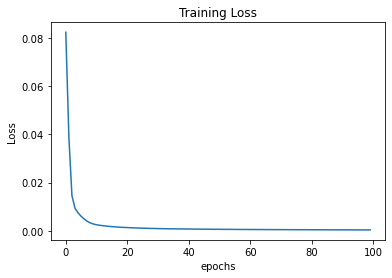

In [19]:
performance_graph(metrics = [loss], title = "Training Loss", xlabel = 'epochs', ylabel = 'Loss')

# Validation

In [20]:
#Function to calculate the mean squared error between two points
#
#Inputs:
#    actual: Python list of actual values
#    predicted: Python list of predicted values
#
#Outputs:
#    loss_vales: Python list of losses calculated from the list of actual and predicted values given

def individual_loss(actual, predicted):
    loss_values = []
    for actual_value, predicted_value in zip(actual, predicted):
        loss = math.pow((actual_value - predicted_value), 2)
        loss_values.append(loss)
    return loss_values


#Function to calculate the averaged total loss
#
#Inputs:
#    loss_values: Python list of loss values where the averaged loss is calculated from
#
#Outputs:
#    loss: The averaged loss calculated from the list of loss_values given

def total_loss(loss_values):
    loss = sum(loss_values) / len(loss_values)
    return loss

In [21]:
# make predictions
x_test = np.array(x_test)
y_test = np.array(y_test)
test_prediction = model.predict(x_test)

#Calculate the mean squared error wrt to the normalised values
loss_values = individual_loss(y_test, test_prediction)

#Calculate the total loss
t_loss = total_loss(loss_values)

#Convert the normalized prediction anda acutal values back to the glucose values
prediction = scaler.inverse_transform(test_prediction).squeeze()
actual = y_test.reshape(-1,1) #Reshape to fit to the scaler
actual = scaler.inverse_transform(actual).squeeze()

### Checkpoint 6: Graph the remaining instances and plot them (Provide the true data and the validated data on the same graph), display the mean loss for each of the instance.

#### Graph

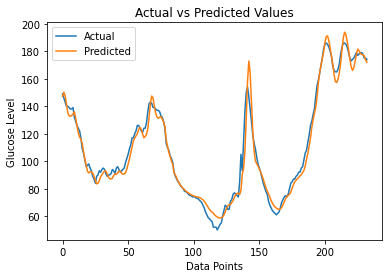

In [22]:
performance_graph(metrics = [actual, prediction], title = "Actual vs Predicted Values", xlabel = "Data Points",
                  ylabel = "Glucose Level", legend = ["Actual", "Predicted"])

#### Table of Actual, Predicted and Loss Values

In [23]:
result_frame = pd.DataFrame()
result_frame["Actual"] = actual
result_frame["Prediction"] = prediction
result_frame['Loss'] = loss_values

print(f"Total Averaged Loss: {t_loss}")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(result_frame)


Total Averaged Loss: 0.00027624107207094924
         Actual  Prediction          Loss
0    149.000000  147.294373  2.257225e-05
1    146.000000  150.175720  1.352929e-04
2    143.000000  147.552933  1.608397e-04
3    140.000000  141.732620  2.329238e-05
4    140.000000  135.567261  1.524598e-04
5    139.000000  132.990234  2.802364e-04
6    138.000000  132.718674  2.164194e-04
7    138.000000  133.290573  1.720866e-04
8    139.000000  134.361389  1.669501e-04
9    132.000000  136.015717  1.251227e-04
10   129.000000  131.550247  5.046314e-05
11   125.999992  125.730721  5.626196e-07
12   123.999992  120.667297  8.617918e-05
13   122.000000  117.588181  1.510243e-04
14   117.000000  115.928741  8.904358e-06
15   109.000000  112.891258  1.174878e-04
16   106.000000  106.654182  3.320588e-06
17   101.000000  101.571716  2.536158e-06
18    96.000000   96.994896  7.680121e-06
19    97.000000   92.744919  1.404839e-04
20    97.999992   91.467667  3.310912e-04
21    94.999992   92.340416  5.4

# Optimisation

### Checkpoint 7: Write a short report presenting your analysis on the optimal hyper-parameter of choice. You may include the necessary graphs or printout to explain your optimal hyper-parameter of choice.

There are three hyperparameters that I would like to tune and they are:
1. Output Dimension of the LSTM cell
2. Activation function of the last layer of the model
3. Window Size

**Output Dimension**
For the output dimension of the LSTM cell, I am not very clear as to how much this will impact the performance of the model. Intuitively, more dimensions will be able to encode more dimensions and would probably give better results. However, having too many dimensions might result in encoding more information than needed, and will lead to overfitting. On the other hand, having too little dimension might result in the model not performing well. Hence we need to tune the value for this in order to find the best value.

**Activation**
For the activation function, intuitively we would use sigmoid as the dataset has been normalized to the range of 0-1. The sigmoid function also produces data in that specific range. However, this range of 0-1 is normalized from our training dataset. This means that the maximum and minimum glucose value that the model will be able to predict will be the respective maximum and minimum value that it has seen from the training dataset. Depending on the inputs to the model, there might be a need to go higher or lower. Hence I would like to test using relu, which will allow the model to output values from 0 onwards, and leakyrelu which behaves like relu but will allow the model to output negative values as well.

**Sizes**
The window size determines how many input values are being fed to the model for it to predict the next value. Intuitively, more input values would suggest better performance as the model has more values to work with. However, using too high of a window size might result in lesser training data for the model to work with. The objective of this hyperparameter tuning is to find the best window size that will work for this particular model and dataset. Therefore, in this exercise, I will be using a maximum window size of 29 as one of the sub-dataset that we are working with only has 30 values, thus only allowing for a window size of 29.

**Method**
In order to find the best hyperparameter, I will be putting down the different values that I would like to try in a list. The method will then be to iterate through the different list, and for every combination of hyperparameters available, train the model with the respective hyperparameter value and find the combination of hyperparameter that will give the lowest loss on the test set.

In [24]:
#HyperParameters to try
output_dims = [1, 2, 3, 4, 5, 10, 15,20]
activations = ['relu', 'LeakyReLU', 'sigmoid']
sizes = [6,12,18,24,29]

In [25]:
#Function to split the data, create the model and run the training with the given inputs
#
#Inputs:
#    output_dim: Python integer to determine the output dimension of the LSTM cell
#    activation: String to determine the activation function for the last layer of the model
#    size: Python integer to determine the window size
#
#Outputs:
#    t_loss: The total loss calculated from the training the model on the given hyperparameters and testing it on the test set


def fit_all(output_dim, activation, size):
    x_train = []
    y_train = []
    x_test = []
    y_test = []

    #Get the training and test sets
    for i, dataset in enumerate(datasets):
        #Split the data points into windows
        x_data, y_data = create_window(dataset,scaler, size)

        #Datasets 4,5 and 6 will be added to the test set
        if i >= 4 and i <=6:
            x_test.extend(x_data)
            y_test.extend(y_data)
        #Rest of the data will be added to the training set
        else:
            x_train.extend(x_data)
            y_train.extend(y_data)

    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    
    #Create model
    model = create_model(output_dim, activation)
    
    history = model.fit(x_train, y_train, epochs=30, verbose=0)
    loss = history.history['loss']
    
    #Get Predictions
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    test_prediction = model.predict(x_test)
    
    #Calculate the mean squared error wrt to the normalised values
    loss_values = individual_loss(y_test, test_prediction)
    
    #Calculate the total loss
    t_loss = total_loss(loss_values)
    
    #Convert the normalized prediction anda acutal values back to the glucose values
    prediction = scaler.inverse_transform(test_prediction).squeeze()
    actual = y_test.reshape(-1,1)
    actual = scaler.inverse_transform(actual).squeeze()
    
    #Print Graph
    performance_graph(metrics = [actual, prediction], title = "Actual vs Predicted Values", xlabel = "Data Points",
                  ylabel = "Glucose Level", legend = ["Actual", "Predicted"])
    
    return t_loss

In [28]:
#Function to run the training multiple times using different hyperparams provided
#
#Inputs:
#    output_dims: Python list of differnt values of output_dims for the LSTM output dimension
#    activations: Python list of different activation functions for the last layer of the model
#    sizes: Python list of different window_sizes for the data
#
#Outputs:
#    best_combo: Python dictionary with the best hyperparameter combination that resulted in the lowest loss
#    loss: Float value for the lowest loss obtained from among all the hyperparameter combination

def perform_search(output_dims, activations, sizes):
    #To record the best loss and best hyperparams
    best_loss = 10000
    best_combo = {'output_dim': None, 'activation':None, 'size': None}
    counter = 0
    #Try all Combinations of hyperparams
    for dim in output_dims:
        for acti in activations:
            for size in sizes:
                print(f"Iteration {counter}: output_dim = {dim}, activation = {acti}, size = {size}")
                loss = fit_all(dim, acti, size)
                print(f"Loss: {loss}\n")
                counter += 1
                if loss < best_loss:
                    best_loss = loss
                    best_combo['output_dim'] = dim
                    best_combo['activation'] = acti
                    best_combo['size'] = size
                else:
                    continue
    return best_combo, best_loss

Iteration 0: output_dim = 1, activation = relu, size = 6


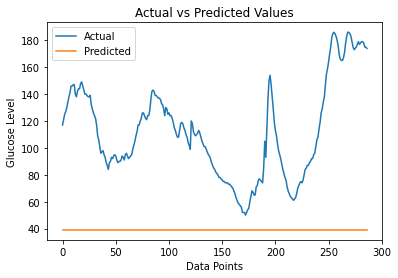

Loss: 0.0511813467785409

Iteration 1: output_dim = 1, activation = relu, size = 12


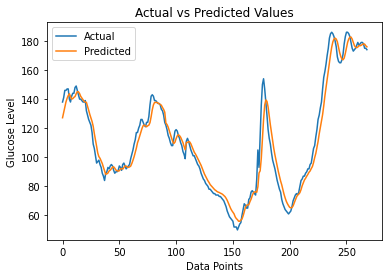

Loss: 0.0004741752219923102

Iteration 2: output_dim = 1, activation = relu, size = 18


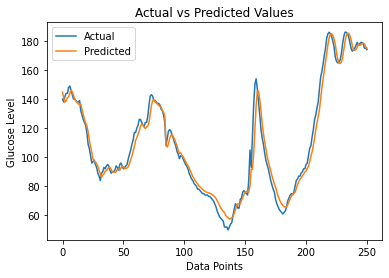

Loss: 0.0003212998433490123

Iteration 3: output_dim = 1, activation = relu, size = 24


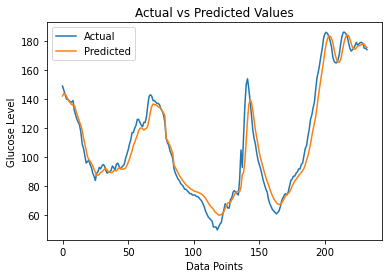

Loss: 0.0005329674948195085

Iteration 4: output_dim = 1, activation = relu, size = 29


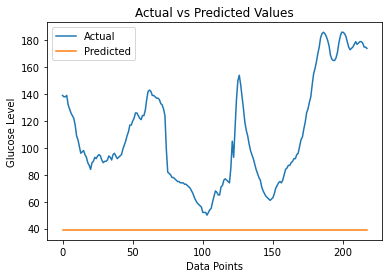

Loss: 0.05085773959078034

Iteration 5: output_dim = 1, activation = LeakyReLU, size = 6


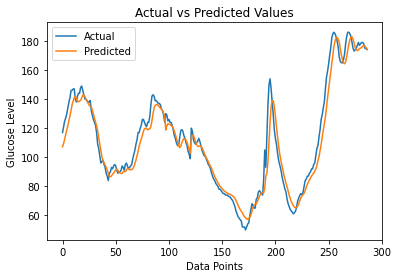

Loss: 0.0005171568881966854

Iteration 6: output_dim = 1, activation = LeakyReLU, size = 12


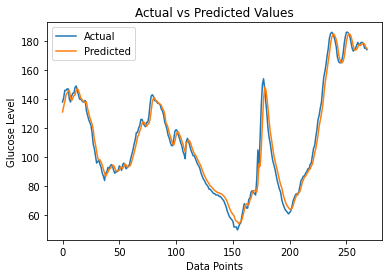

Loss: 0.00024714009401545316

Iteration 7: output_dim = 1, activation = LeakyReLU, size = 18


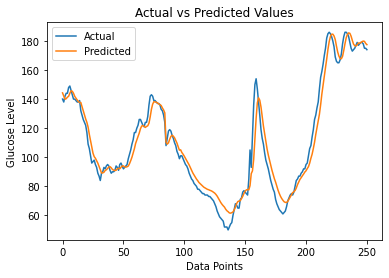

Loss: 0.0005234114411180089

Iteration 8: output_dim = 1, activation = LeakyReLU, size = 24


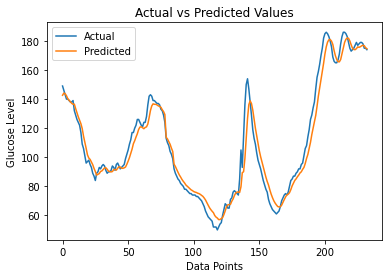

Loss: 0.000499884325242774

Iteration 9: output_dim = 1, activation = LeakyReLU, size = 29


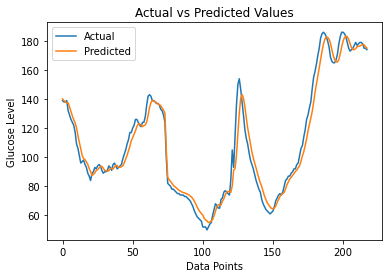

Loss: 0.00043240673050866927

Iteration 10: output_dim = 1, activation = sigmoid, size = 6


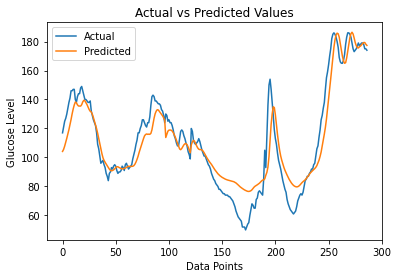

Loss: 0.0011797116923884072

Iteration 11: output_dim = 1, activation = sigmoid, size = 12


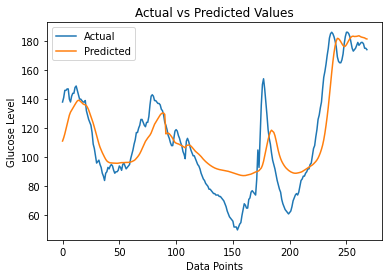

Loss: 0.0025822636214688794

Iteration 12: output_dim = 1, activation = sigmoid, size = 18


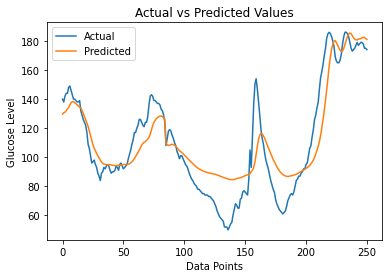

Loss: 0.0021533195280474863

Iteration 13: output_dim = 1, activation = sigmoid, size = 24


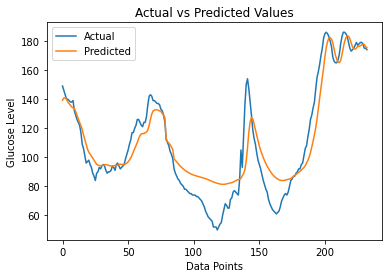

Loss: 0.001573477011322843

Iteration 14: output_dim = 1, activation = sigmoid, size = 29


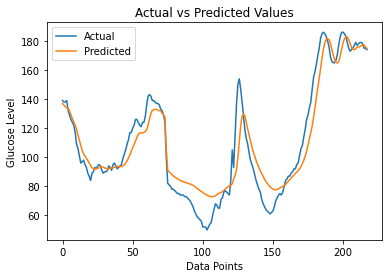

Loss: 0.001221562315764455

Iteration 15: output_dim = 2, activation = relu, size = 6


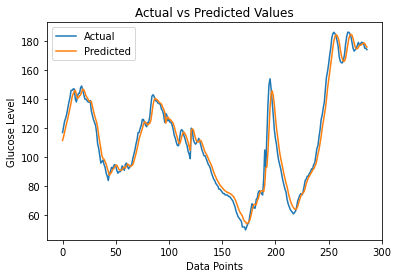

Loss: 0.00031836236859694196

Iteration 16: output_dim = 2, activation = relu, size = 12


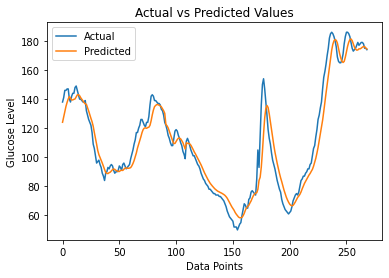

Loss: 0.0007047369843900091

Iteration 17: output_dim = 2, activation = relu, size = 18


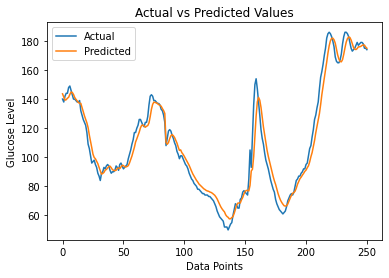

Loss: 0.0004512548763898082

Iteration 18: output_dim = 2, activation = relu, size = 24


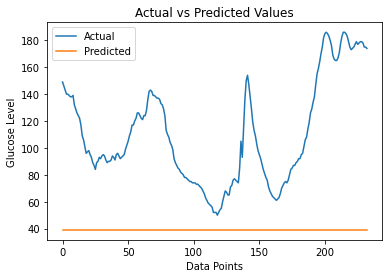

Loss: 0.05058047862820743

Iteration 19: output_dim = 2, activation = relu, size = 29


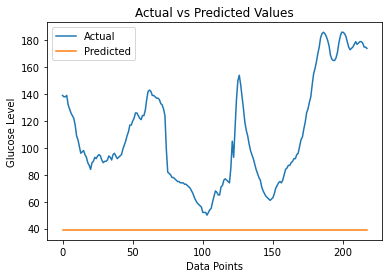

Loss: 0.05085773959078034

Iteration 20: output_dim = 2, activation = LeakyReLU, size = 6


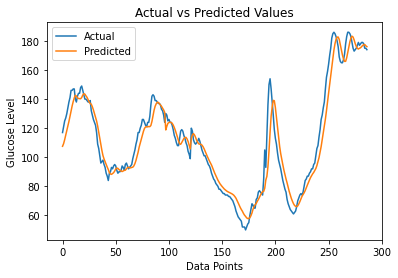

Loss: 0.0006818598563024842

Iteration 21: output_dim = 2, activation = LeakyReLU, size = 12


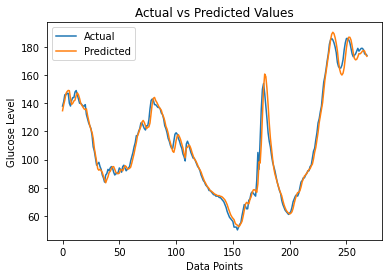

Loss: 0.000189654081982732

Iteration 22: output_dim = 2, activation = LeakyReLU, size = 18


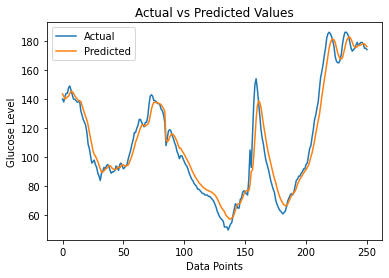

Loss: 0.0005139337418375638

Iteration 23: output_dim = 2, activation = LeakyReLU, size = 24


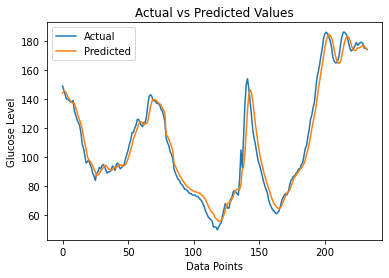

Loss: 0.00038604875288311246

Iteration 24: output_dim = 2, activation = LeakyReLU, size = 29


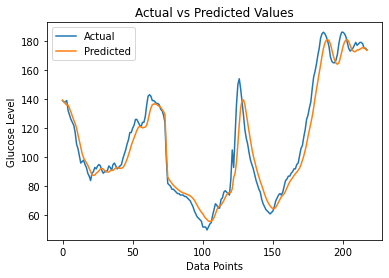

Loss: 0.0006303028018112722

Iteration 25: output_dim = 2, activation = sigmoid, size = 6


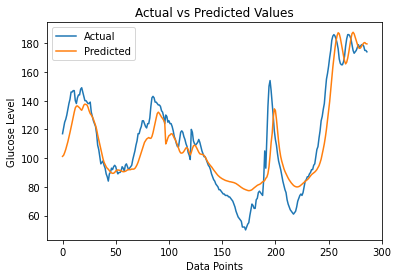

Loss: 0.00159139469531512

Iteration 26: output_dim = 2, activation = sigmoid, size = 12


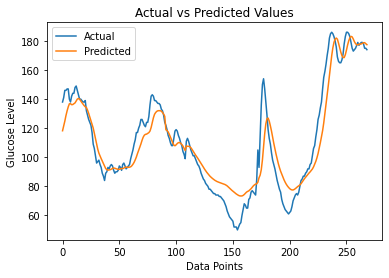

Loss: 0.0012284864333535924

Iteration 27: output_dim = 2, activation = sigmoid, size = 18


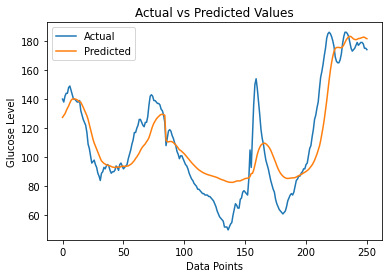

Loss: 0.0023528497256442194

Iteration 28: output_dim = 2, activation = sigmoid, size = 24


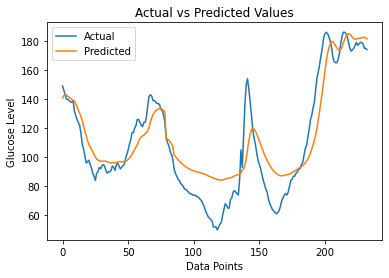

Loss: 0.0021075013481583874

Iteration 29: output_dim = 2, activation = sigmoid, size = 29


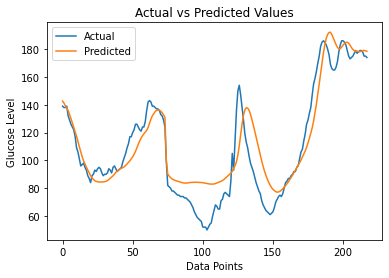

Loss: 0.00189983491270102

Iteration 30: output_dim = 3, activation = relu, size = 6


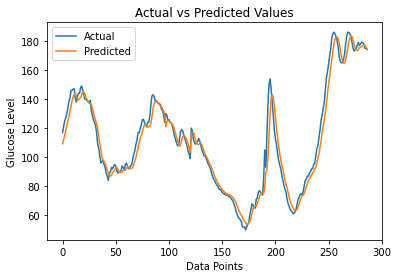

Loss: 0.0003906400658496426

Iteration 31: output_dim = 3, activation = relu, size = 12


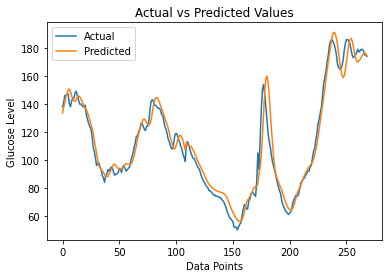

Loss: 0.0004771282698619359

Iteration 32: output_dim = 3, activation = relu, size = 18


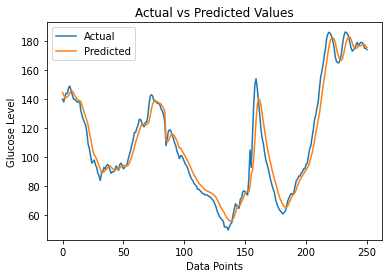

Loss: 0.0005091605458424483

Iteration 33: output_dim = 3, activation = relu, size = 24


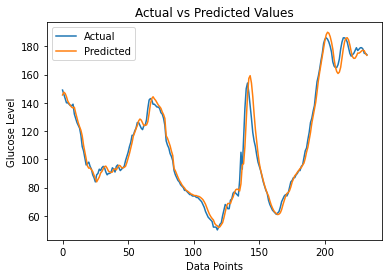

Loss: 0.00025094037389629387

Iteration 34: output_dim = 3, activation = relu, size = 29


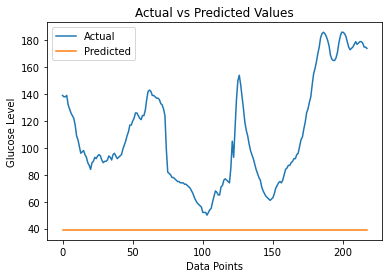

Loss: 0.05085773959078034

Iteration 35: output_dim = 3, activation = LeakyReLU, size = 6


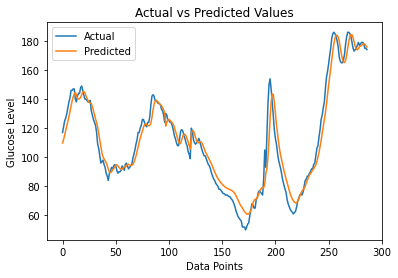

Loss: 0.000490654927072325

Iteration 36: output_dim = 3, activation = LeakyReLU, size = 12


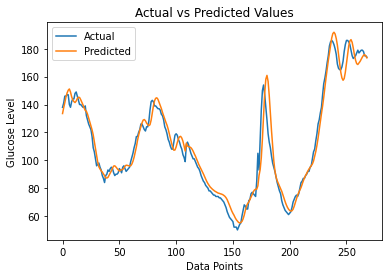

Loss: 0.00048641027722180964

Iteration 37: output_dim = 3, activation = LeakyReLU, size = 18


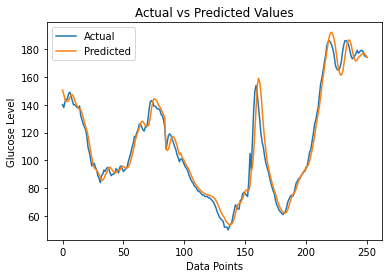

Loss: 0.0003398122985134169

Iteration 38: output_dim = 3, activation = LeakyReLU, size = 24


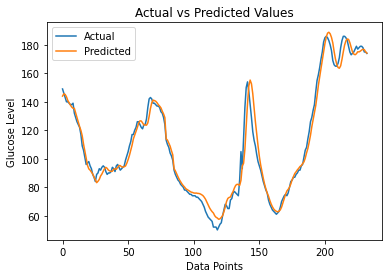

Loss: 0.00033277905052816483

Iteration 39: output_dim = 3, activation = LeakyReLU, size = 29


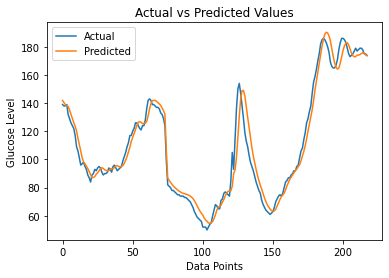

Loss: 0.00048555864618095437

Iteration 40: output_dim = 3, activation = sigmoid, size = 6


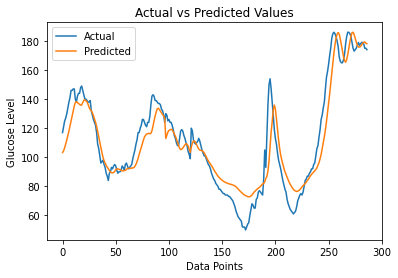

Loss: 0.0012148428390892766

Iteration 41: output_dim = 3, activation = sigmoid, size = 12


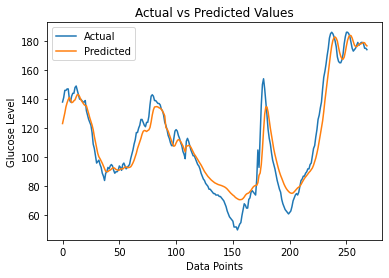

Loss: 0.0007948973180019398

Iteration 42: output_dim = 3, activation = sigmoid, size = 18


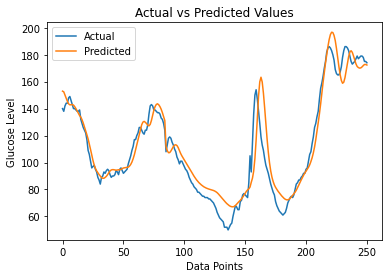

Loss: 0.0010313405396052092

Iteration 43: output_dim = 3, activation = sigmoid, size = 24


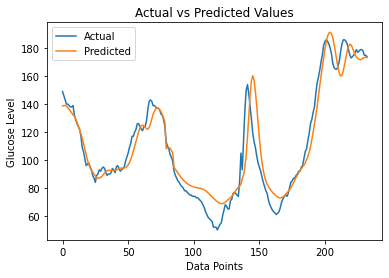

Loss: 0.0010502942278469989

Iteration 44: output_dim = 3, activation = sigmoid, size = 29


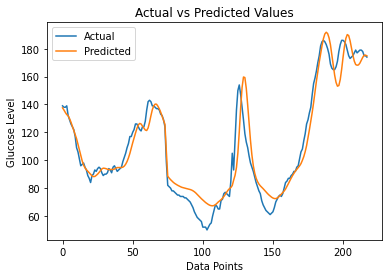

Loss: 0.0009421441137983415

Iteration 45: output_dim = 4, activation = relu, size = 6


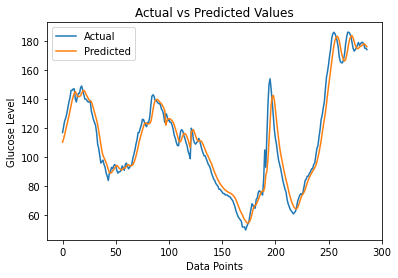

Loss: 0.0004938065004644147

Iteration 46: output_dim = 4, activation = relu, size = 12


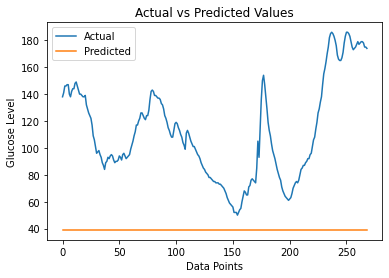

Loss: 0.051024735771159756

Iteration 47: output_dim = 4, activation = relu, size = 18


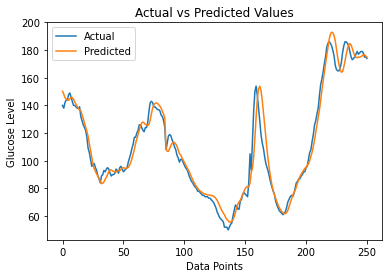

Loss: 0.00045883934729226017

Iteration 48: output_dim = 4, activation = relu, size = 24


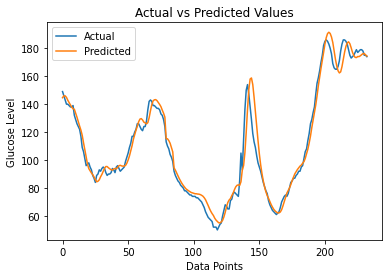

Loss: 0.0004464029728847273

Iteration 49: output_dim = 4, activation = relu, size = 29


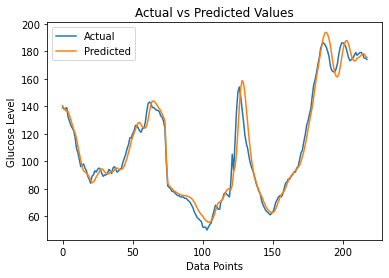

Loss: 0.00038564932379278084

Iteration 50: output_dim = 4, activation = LeakyReLU, size = 6


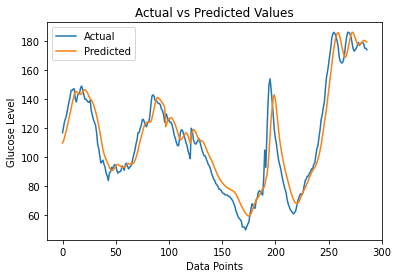

Loss: 0.0008075271603871361

Iteration 51: output_dim = 4, activation = LeakyReLU, size = 12


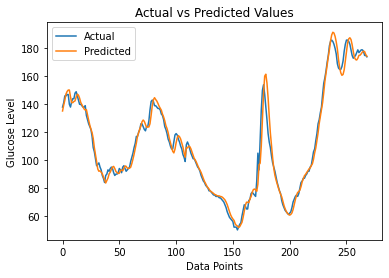

Loss: 0.00023497335097456953

Iteration 52: output_dim = 4, activation = LeakyReLU, size = 18


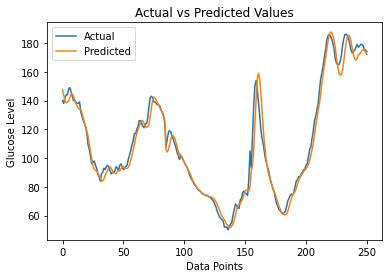

Loss: 0.00031908644122888053

Iteration 53: output_dim = 4, activation = LeakyReLU, size = 24


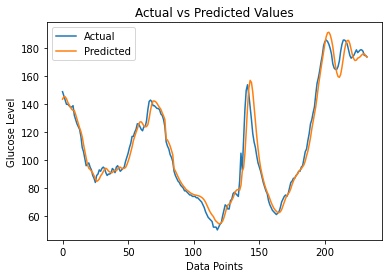

Loss: 0.00037366908064859287

Iteration 54: output_dim = 4, activation = LeakyReLU, size = 29


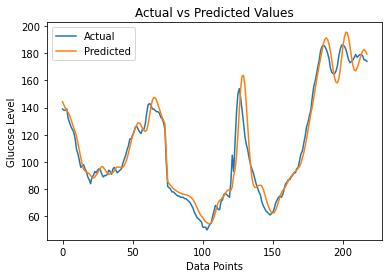

Loss: 0.0005191478103548007

Iteration 55: output_dim = 4, activation = sigmoid, size = 6


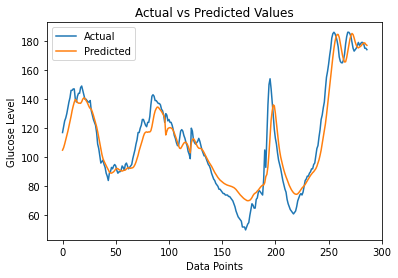

Loss: 0.0009005000970339755

Iteration 56: output_dim = 4, activation = sigmoid, size = 12


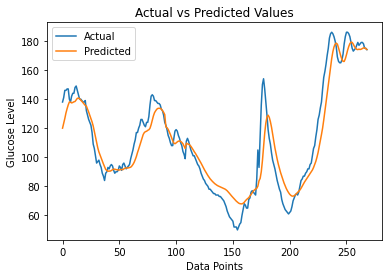

Loss: 0.0010864176854931571

Iteration 57: output_dim = 4, activation = sigmoid, size = 18


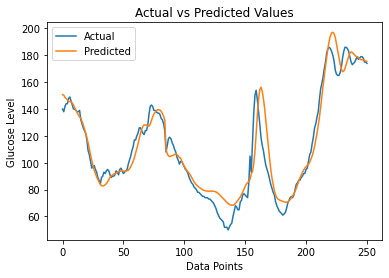

Loss: 0.0008960728634662974

Iteration 58: output_dim = 4, activation = sigmoid, size = 24


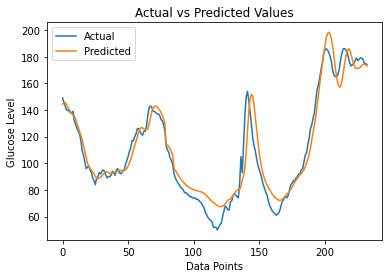

Loss: 0.0007487597299820342

Iteration 59: output_dim = 4, activation = sigmoid, size = 29


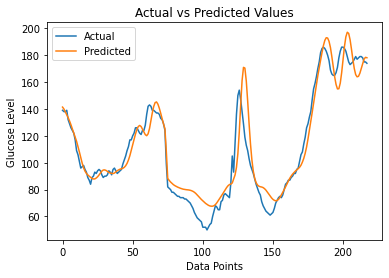

Loss: 0.0010961457863166084

Iteration 60: output_dim = 5, activation = relu, size = 6


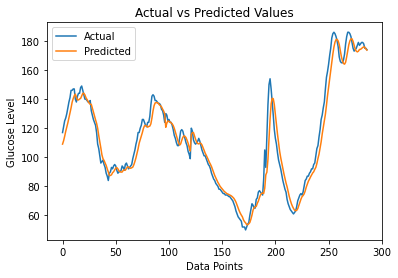

Loss: 0.00045745012940309634

Iteration 61: output_dim = 5, activation = relu, size = 12


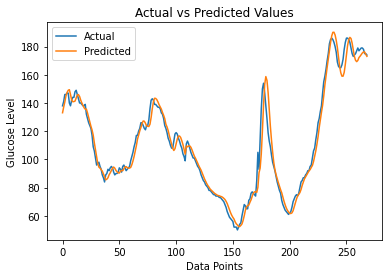

Loss: 0.00033324211474578886

Iteration 62: output_dim = 5, activation = relu, size = 18


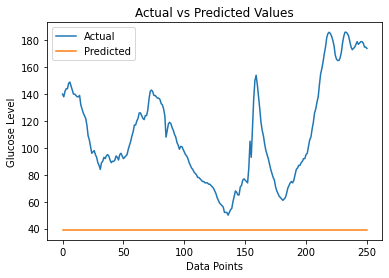

Loss: 0.05067044929125701

Iteration 63: output_dim = 5, activation = relu, size = 24


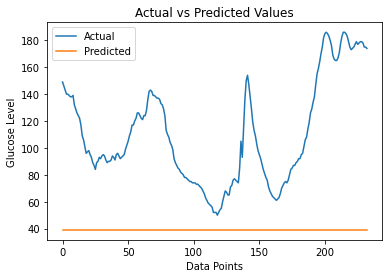

Loss: 0.05058047862820743

Iteration 64: output_dim = 5, activation = relu, size = 29


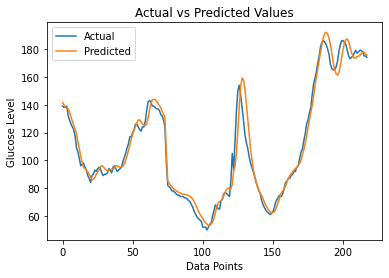

Loss: 0.0004068815575923343

Iteration 65: output_dim = 5, activation = LeakyReLU, size = 6


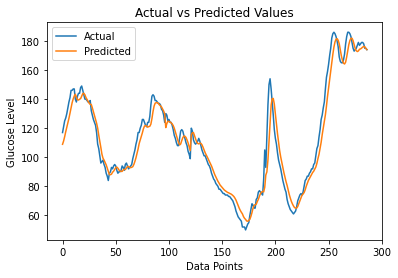

Loss: 0.0004822579735649531

Iteration 66: output_dim = 5, activation = LeakyReLU, size = 12


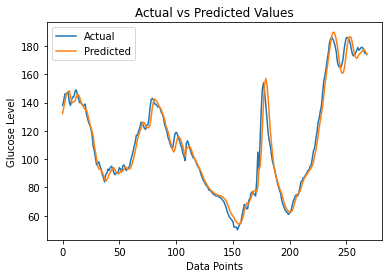

Loss: 0.0002788466444378172

Iteration 67: output_dim = 5, activation = LeakyReLU, size = 18


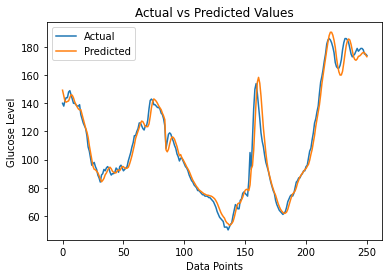

Loss: 0.00029366299833948685

Iteration 68: output_dim = 5, activation = LeakyReLU, size = 24


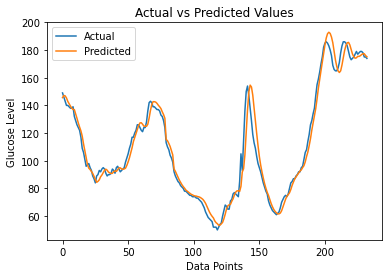

Loss: 0.00037849119745219794

Iteration 69: output_dim = 5, activation = LeakyReLU, size = 29


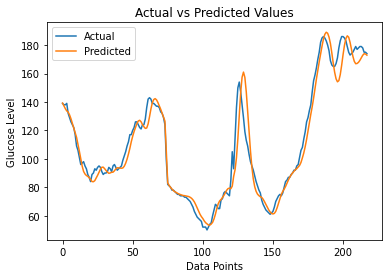

Loss: 0.0005975294586946387

Iteration 70: output_dim = 5, activation = sigmoid, size = 6


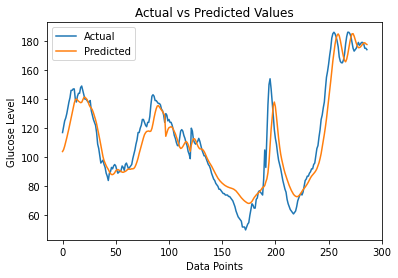

Loss: 0.0010548212611142182

Iteration 71: output_dim = 5, activation = sigmoid, size = 12


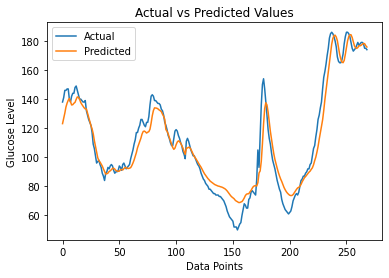

Loss: 0.0006867420782733552

Iteration 72: output_dim = 5, activation = sigmoid, size = 18


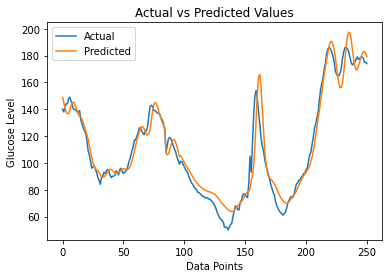

Loss: 0.0006250634732010024

Iteration 73: output_dim = 5, activation = sigmoid, size = 24


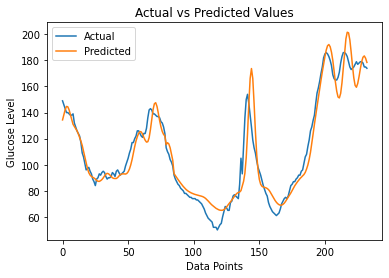

Loss: 0.0009070209500958981

Iteration 74: output_dim = 5, activation = sigmoid, size = 29


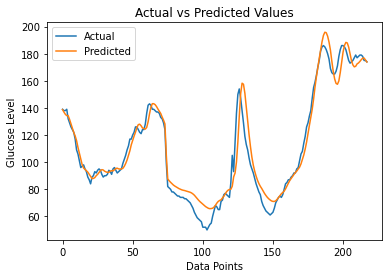

Loss: 0.0006115170683211834

Iteration 75: output_dim = 10, activation = relu, size = 6


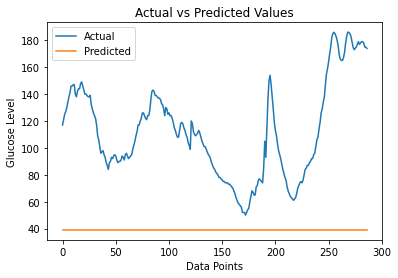

Loss: 0.0511813467785409

Iteration 76: output_dim = 10, activation = relu, size = 12


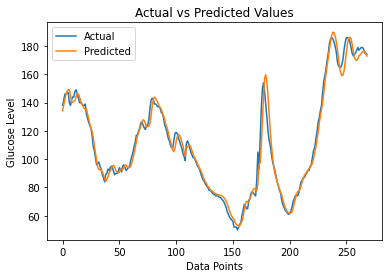

Loss: 0.00024012035615158438

Iteration 77: output_dim = 10, activation = relu, size = 18


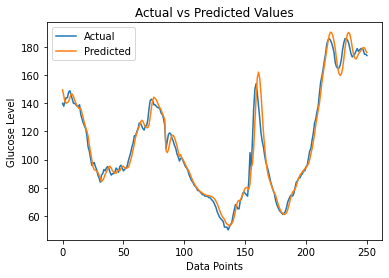

Loss: 0.00028572335932639084

Iteration 78: output_dim = 10, activation = relu, size = 24


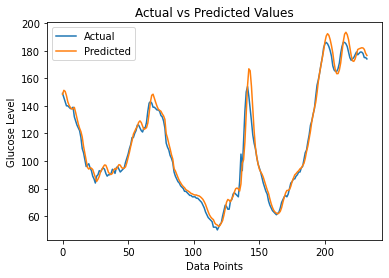

Loss: 0.0002290062935834797

Iteration 79: output_dim = 10, activation = relu, size = 29


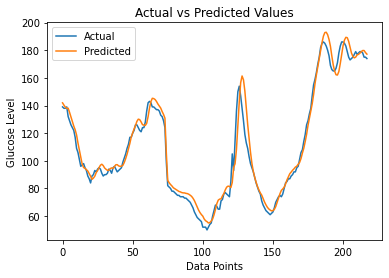

Loss: 0.0003784177219091921

Iteration 80: output_dim = 10, activation = LeakyReLU, size = 6


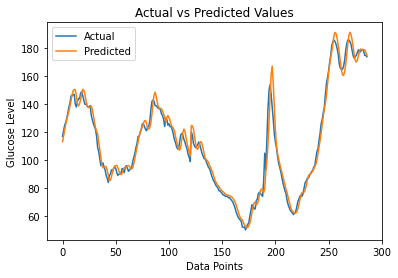

Loss: 0.00024697936723222616

Iteration 81: output_dim = 10, activation = LeakyReLU, size = 12


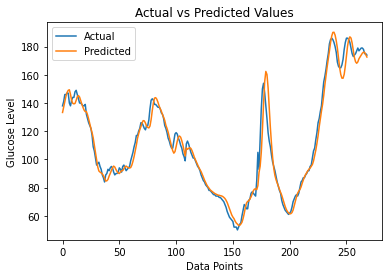

Loss: 0.00034688489224518593

Iteration 82: output_dim = 10, activation = LeakyReLU, size = 18


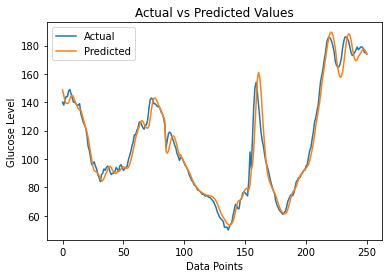

Loss: 0.0003290944132482563

Iteration 83: output_dim = 10, activation = LeakyReLU, size = 24


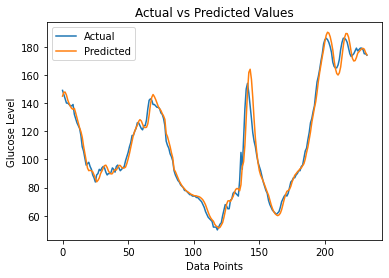

Loss: 0.00025473804189988006

Iteration 84: output_dim = 10, activation = LeakyReLU, size = 29


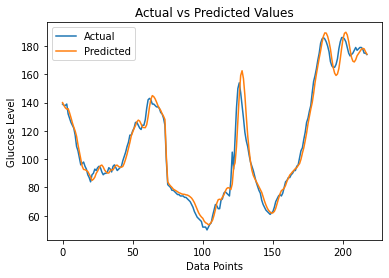

Loss: 0.0002990318438736666

Iteration 85: output_dim = 10, activation = sigmoid, size = 6


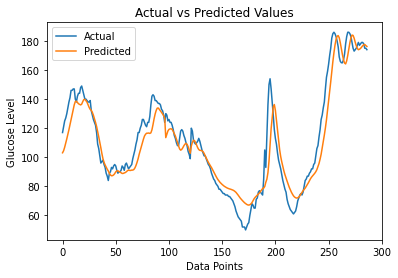

Loss: 0.0010435048253776718

Iteration 86: output_dim = 10, activation = sigmoid, size = 12


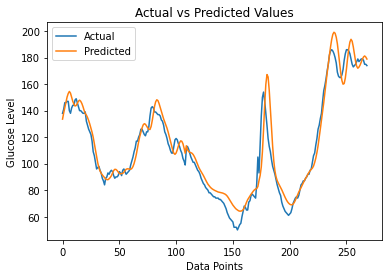

Loss: 0.0007658472354390899

Iteration 87: output_dim = 10, activation = sigmoid, size = 18


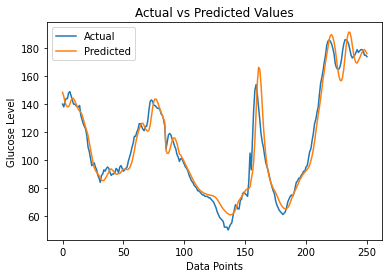

Loss: 0.0005302798399090642

Iteration 88: output_dim = 10, activation = sigmoid, size = 24


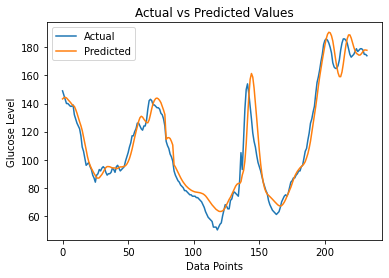

Loss: 0.0007081212886984965

Iteration 89: output_dim = 10, activation = sigmoid, size = 29


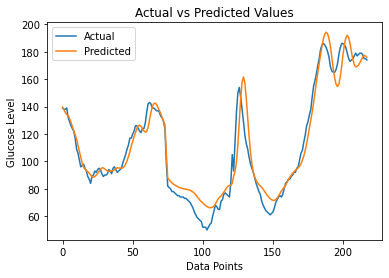

Loss: 0.0007578063189201136

Iteration 90: output_dim = 15, activation = relu, size = 6


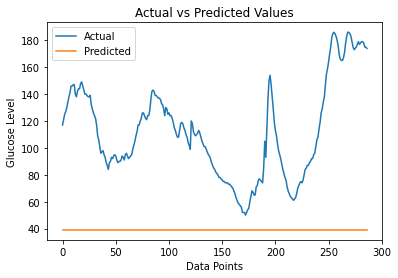

Loss: 0.0511813467785409

Iteration 91: output_dim = 15, activation = relu, size = 12


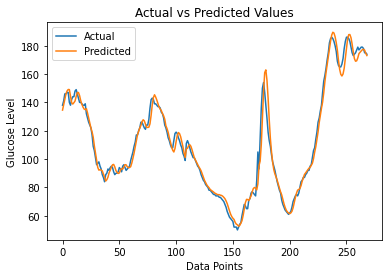

Loss: 0.00023609776574054863

Iteration 92: output_dim = 15, activation = relu, size = 18


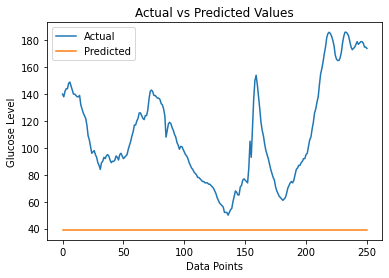

Loss: 0.05067044929125701

Iteration 93: output_dim = 15, activation = relu, size = 24


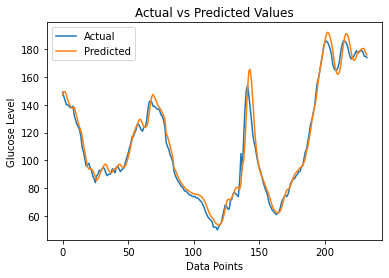

Loss: 0.0002642752608669476

Iteration 94: output_dim = 15, activation = relu, size = 29


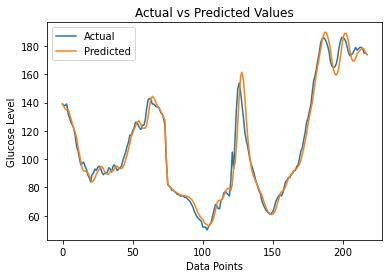

Loss: 0.0002758362628346373

Iteration 95: output_dim = 15, activation = LeakyReLU, size = 6


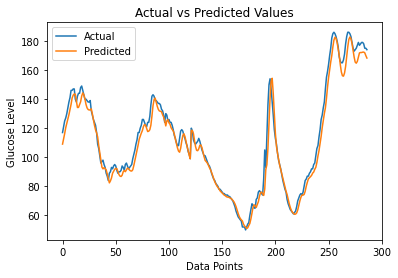

Loss: 0.00030346044353335

Iteration 96: output_dim = 15, activation = LeakyReLU, size = 12


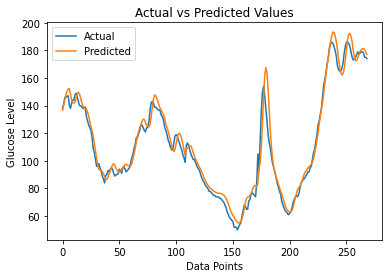

Loss: 0.0003462817293714918

Iteration 97: output_dim = 15, activation = LeakyReLU, size = 18


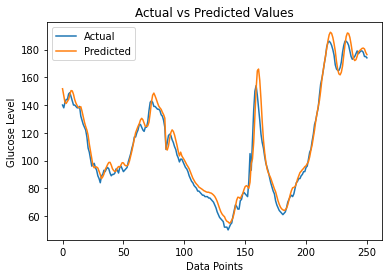

Loss: 0.0002872455693715719

Iteration 98: output_dim = 15, activation = LeakyReLU, size = 24


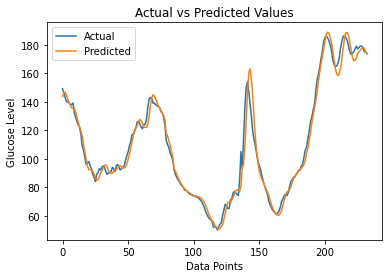

Loss: 0.00027407305326780765

Iteration 99: output_dim = 15, activation = LeakyReLU, size = 29


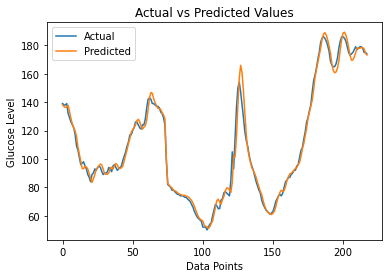

Loss: 0.00016192358564412422

Iteration 100: output_dim = 15, activation = sigmoid, size = 6


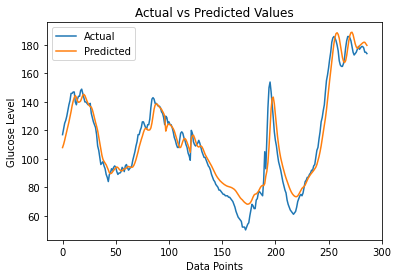

Loss: 0.0006689523657993123

Iteration 101: output_dim = 15, activation = sigmoid, size = 12


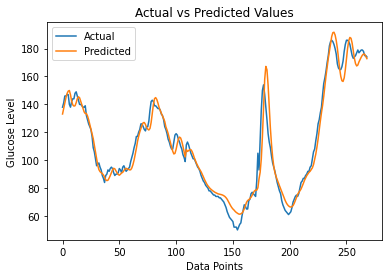

Loss: 0.0004654069936050579

Iteration 102: output_dim = 15, activation = sigmoid, size = 18


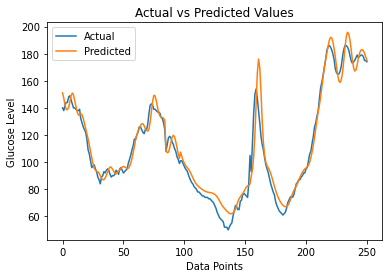

Loss: 0.0004896768689319454

Iteration 103: output_dim = 15, activation = sigmoid, size = 24


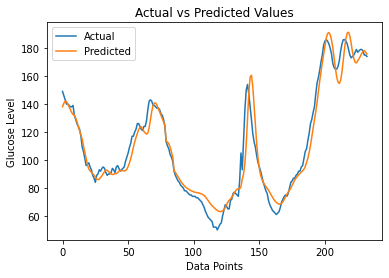

Loss: 0.000621463907903815

Iteration 104: output_dim = 15, activation = sigmoid, size = 29


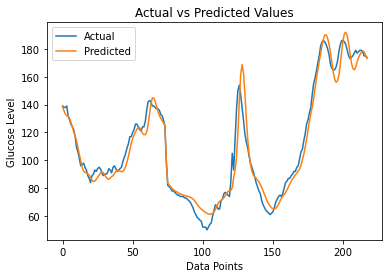

Loss: 0.0005104100197835522

Iteration 105: output_dim = 20, activation = relu, size = 6


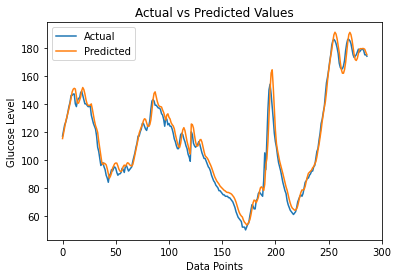

Loss: 0.0002353688506202786

Iteration 106: output_dim = 20, activation = relu, size = 12


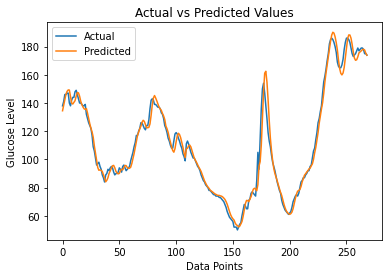

Loss: 0.0002272164444355456

Iteration 107: output_dim = 20, activation = relu, size = 18


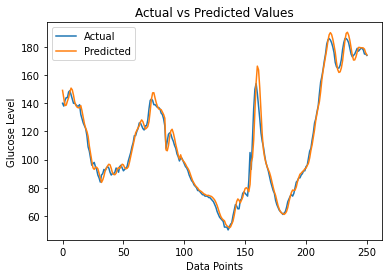

Loss: 0.00018504815917773552

Iteration 108: output_dim = 20, activation = relu, size = 24


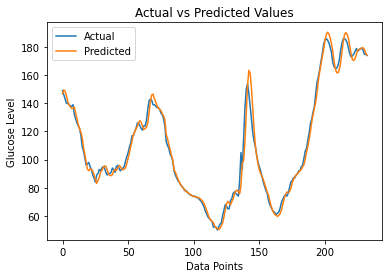

Loss: 0.00019326317000168956

Iteration 109: output_dim = 20, activation = relu, size = 29


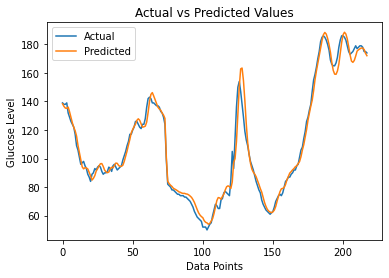

Loss: 0.00023669947222086052

Iteration 110: output_dim = 20, activation = LeakyReLU, size = 6


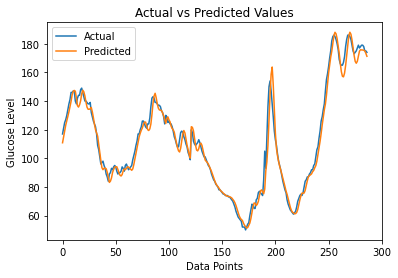

Loss: 0.00023688230176016105

Iteration 111: output_dim = 20, activation = LeakyReLU, size = 12


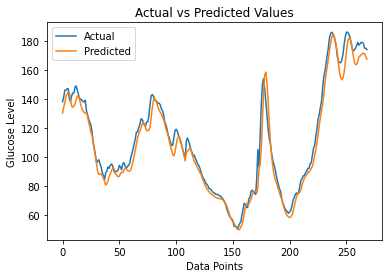

Loss: 0.0003781024629556733

Iteration 112: output_dim = 20, activation = LeakyReLU, size = 18


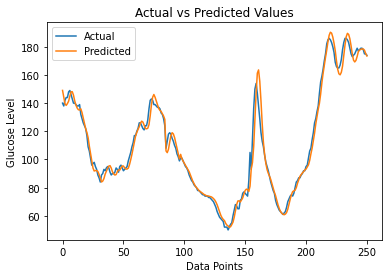

Loss: 0.0002472871921312866

Iteration 113: output_dim = 20, activation = LeakyReLU, size = 24


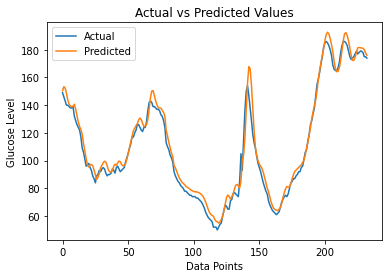

Loss: 0.0002784945969299749

Iteration 114: output_dim = 20, activation = LeakyReLU, size = 29


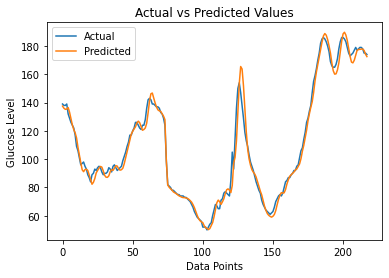

Loss: 0.00021157127189449593

Iteration 115: output_dim = 20, activation = sigmoid, size = 6


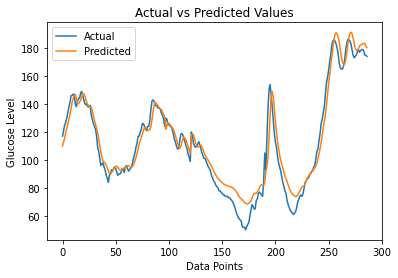

Loss: 0.0005492375013143885

Iteration 116: output_dim = 20, activation = sigmoid, size = 12


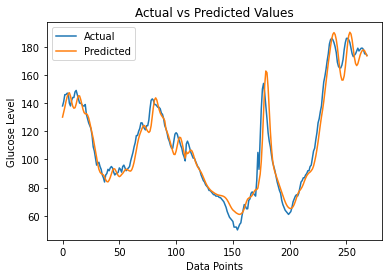

Loss: 0.000499779945648343

Iteration 117: output_dim = 20, activation = sigmoid, size = 18


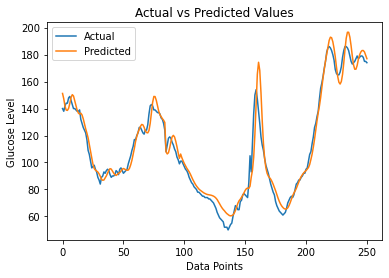

Loss: 0.00046619865337536073

Iteration 118: output_dim = 20, activation = sigmoid, size = 24


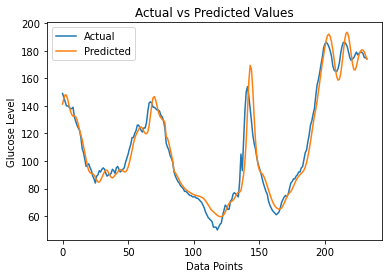

Loss: 0.0005287381838545772

Iteration 119: output_dim = 20, activation = sigmoid, size = 29


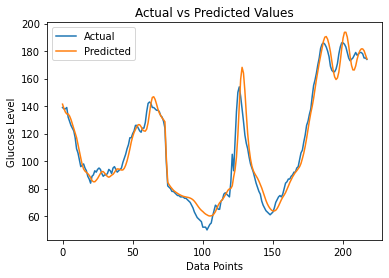

Loss: 0.00047732525451263613



In [29]:
#Run the search for the best hyperparameters
best_combo, best_loss = perform_search(output_dims, activations, sizes)

In [30]:
#Print findings
print(best_combo)
print(best_loss)

{'output_dim': 15, 'activation': 'LeakyReLU', 'size': 29}
0.00016192358564412422


From the print statement above, we can see that the best hyperparameters will be to use a LSTM output dimension of 15, a window size of 29 and to have the activation function for the last layer of the model to be LeakyRelu. This combination of hyperparameters managed to achieve a loss of 0.000162

Keeping the other hyperparameters constant with the best output dimension of 15 and the best activation function LeakyReLU, we can see that when the window size increases, the loss generally decreases. The only exception is when the window size was 12. The loss obtained with a window size of 12 was 0.00034, which is larger than the loss of 0.00030 achieved by window size 6. However, the remaining window sizes of 18, 24 and 29 followed the observation, achieving a loss of 0.000287 and 0.000274 and 0.000162 respectively.

This could be because a larger window size will provide the model with a larger number of inputs. Since we are using an LSTM cell, we do not need to worry too much on overfeeding the model with information as the cell consists of a forget gate that can easily turn off any irrelevant information. Therefore, a larger window size should typically lead to better predictions and a lower loss.